# Accessing ITS_LIVE Data from Cloud-hosted Servers

This notebook will demonstrate how to access [ITS_LIVE](https://its-live.jpl.nasa.gov/#access) data from AWS buckets, and how to do some prelimary data inspection. 

For a more in depth tutorial on how to load in ITS_LIVE data, follow Emma Marshall's tutorial [here](https://e-marshall.github.io/itslive/accessing_s3_data.html)

## Import Packages

In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr

from shapely.geometry import Polygon
from shapely.geometry import Point

import json
import blue_ice_tools as bit
import itslivetools

## ITS_LIVE Data Cube Catalog

The velocity data we will be using is stored in data cubes hosted in AWS severs in the form of `zarr` data cubes. The catalog of datacubes is held in a GeoJSON at the following link `https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json`.

Each entry contains spatial information about the data cube's location and the URL used to access the data. In this tutorial, we will be working with EPSG:3031 / Antarctic Polar Stereographic

In [2]:
catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')
catalog.head()

,fill-opacity,fill,roi_percent_coverage,geometry_epsg,datacube_exist,zarr_url,epsg,FULL_NAME,RGI_CODE,geometry
0,0.984866,red,1.513354,"{'type': 'Polygon', 'coordinates': [[[400000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,Southern Andes,17,"POLYGON ((-76.41134 -50.54338, -75.00000 -50.5..."
1,0.956741,red,4.325908,"{'type': 'Polygon', 'coordinates': [[[400000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,Southern Andes,17,"POLYGON ((-76.38517 -49.64426, -75.00000 -49.6..."
2,0.941388,red,5.861168,"{'type': 'Polygon', 'coordinates': [[[500000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,Southern Andes,17,"POLYGON ((-75.00000 -54.14810, -73.46930 -54.1..."
3,0.794830,red,20.516970,"{'type': 'Polygon', 'coordinates': [[[500000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,Southern Andes,17,"POLYGON ((-75.00000 -53.24927, -73.50155 -53.2..."
4,0.881647,red,11.835322,"{'type': 'Polygon', 'coordinates': [[[500000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,Southern Andes,17,"POLYGON ((-75.00000 -52.35029, -73.53212 -52.3..."


In [3]:
# Clip ITS_LIVE catalog to EPSG:3031, antarctic continent
catalog_sub = catalog[(catalog['epsg'] == 3031) & (catalog['RGI_CODE'] == 19)]
catalog_sub.head()

,fill-opacity,fill,roi_percent_coverage,geometry_epsg,datacube_exist,zarr_url,epsg,FULL_NAME,RGI_CODE,geometry
1640,0.866042,red,13.395802,"{'type': 'Polygon', 'coordinates': [[[-2700000...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,Antarctic and Subantarctic,19,"POLYGON ((-64.29005 -62.91524, -63.43495 -63.6..."
1641,0.767329,red,23.267122,"{'type': 'Polygon', 'coordinates': [[[-2700000...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,Antarctic and Subantarctic,19,"POLYGON ((-62.59242 -62.52573, -61.69924 -63.2..."
1642,0.696583,red,30.341741,"{'type': 'Polygon', 'coordinates': [[[-2700000...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,Antarctic and Subantarctic,19,"POLYGON ((-60.94540 -62.11433, -60.01836 -62.8..."
1643,0.754903,red,24.509684,"{'type': 'Polygon', 'coordinates': [[[-2700000...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,Antarctic and Subantarctic,19,"POLYGON ((-59.34933 -61.68217, -58.39250 -62.4..."
1644,0.941789,red,5.821104,"{'type': 'Polygon', 'coordinates': [[[-2700000...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,Antarctic and Subantarctic,19,"POLYGON ((-57.80427 -61.23039, -56.82149 -61.9..."


**To access data from a separate region,** such as a different projection or by RGI code, change the line `catalog_sub = catalog[catalog['epsg'] == 3031]` to:
- `catalog_sub = catalog[catalog['epsg'] == <EPSG no. here>]`
- `catalog_sub = catalog[catalog['RGI_CODE'] == <RGI no. here>]`

This will return the entries of the catalog where the projection or RGI code match. They can be combined to further refine your search (e.g. areas from EPSG:3031 where the RGI code is 17)

In [4]:
# Grab first entry from sub-catalog
url = catalog_sub.iloc[0]['zarr_url']
url

'http://its-live-data.s3.amazonaws.com/datacubes/v2/S60W060/ITS_LIVE_vel_EPSG3031_G0120_X-2650000_Y1350000.zarr'

This is the URL from the first entry in the sub-catalog for Antarctic areas. This link will download the velocity data calculated by ITS_LIVE from a cloud-hosted AWS server.

## Accessing ITS_LIVE data from Python

For this example, we will use the first entry from the sub-catalog to show how to load in velocity data from the could.

In [5]:
url

'http://its-live-data.s3.amazonaws.com/datacubes/v2/S60W060/ITS_LIVE_vel_EPSG3031_G0120_X-2650000_Y1350000.zarr'

Because the file extension on the end is `.zarr`, we cannot simply call `xr.open_dataset(url)`. That will return an error. <br>
Instead, we must specify the engine used to open the file. In this case, we will pass `engine='zarr'`.

We will also pass the parameter `chunks='auto'`. This introduces Dask, and will allow us to parallelize the data. Using dask will allow us to load in significantly more data than can be hosted in the Kernel.

In [6]:
dc = xr.open_dataset(url, engine='zarr', chunks='auto')

dc

<xarray.Dataset> Size: 23GB
Dimensions:                     (mid_date: 767, y: 833, x: 834)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 6kB 2022-06-13T08:2...
  * x                           (x) float64 7kB -2.7e+06 -2.7e+06 ... -2.6e+06
  * y                           (y) float64 7kB 1.4e+06 1.4e+06 ... 1.3e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 2GB dask.array<chunksize=(767, 200, 200), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 3kB dask.array<chunksize=(767,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 2GB dask.array<chunksize=(767, 200, 200), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 3kB dask.array<chunksize=(767,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] 6kB dask.array<chunksize=(767,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] 6kB dask.array<chunksize=(767,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 3kB dask.array<chunksize=(767,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 3kB dask.array<chunksize=(767,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 3kB dask.array<chunksize=(767,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 3kB dask.array<chunksize=(767,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 3kB dask.array<chunksize=(767,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 3kB dask.array<chunksize=(767,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 07:57:24
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S60W060/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S60W060/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Let's plot the velocity data to see what it even looks like. We will take a mean along the time dimension, then plot the magnitude of velocity

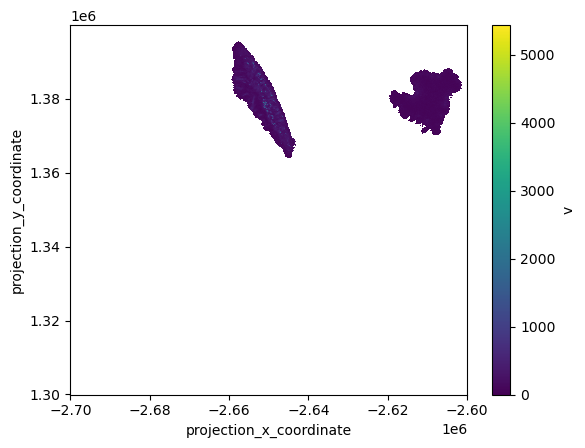

In [7]:
dc.v.mean(dim='mid_date').plot()

From a quick inspection of this plot, there appear to be two islands with a few faster flowing glaciers on the left one.

## Selecting Data Cubes by Point or Shape

I have written a function in `blue_ice_tools.py` that will grab the URLs for a corresponding point, list of points, or a shape passed through a GeoDataFrame. For this example, I will look at the Shirase Glacier in Antarctica.

In [8]:
bit.get_urls?

Signature:
bit.get_urls(
    area: geopandas.geodataframe.GeoDataFrame | tuple | list = None,
    epsg: int = 3031,
) -> list
Docstring:
Given a GDF area or a point in EPSG:4326, return URL or list of URLs
that cover the area or point of areas.

Parameters
----------
area (gpd.GeoDataFrame | tuple | list):
    GeoDataFrame of the reference area, a singular point as a list or tuple,
    or a list or tuple of points.

epsg (int, optional):
    integer value of the CRS of the GeoDataFrame passed. Default: 3031

Returns
-------
urls:
    list of URLs to download data
File:      ~/blue-ice/notebooks/blue_ice_tools.py
Type:      function

The parameters of the function are the gdf or point(s) and the EPSG of the gdf or point(s). If you look closely, this function can run without any parameters being passed. 
- If you pass no parameters, it will return all of the Data Cube URLs for EPSG:3031
- If you only pass an EPSG, it will return all URLs for that projection
- If you specify a shape or point(s) not in EPSG:3031, make sure to specify which projection you are using

The function acts almost as a wrapper to `itslivetools.find_granule_by_point`. It provides multi-point functionality, and adds the ability to return all data cubes required to analyze a large area (such as a large glacier covering two or more data cubes)

If when using this function, you receive and error stating that 'index 0 is out of range', make sure your points as passed as (lon, lat), and are valid points that ITS_LIVE has data for in EPSG:4326

In [9]:
# Coordinates for the two data cubes on shirase
pts = ((39, -70), (39, -71))

# Shapefile loaded into GDF for shirase
shirase_outline = gpd.read_file('../data/shirase-glacier/shirase.shp')
shirase_outline

,OBJECTID,Id,area_km2,perim_km,geometry
0,20484,18637,1943.2,584.2,"POLYGON ((1363196.981 1723984.841, 1370628.789..."


In [10]:
pt_urls = bit.get_urls(pts)
pt_urls

['http://its-live-data.s3.amazonaws.com/datacubes/v2/S60E030/ITS_LIVE_vel_EPSG3031_G0120_X1350000_Y1750000.zarr',
 'http://its-live-data.s3.amazonaws.com/datacubes/v2/S70E030/ITS_LIVE_vel_EPSG3031_G0120_X1350000_Y1650000.zarr']

In [11]:
shp_urls = bit.get_urls(shirase_outline)

shp_urls

['http://its-live-data.s3.amazonaws.com/datacubes/v2/S70E030/ITS_LIVE_vel_EPSG3031_G0120_X1350000_Y1650000.zarr',
 'http://its-live-data.s3.amazonaws.com/datacubes/v2/S60E030/ITS_LIVE_vel_EPSG3031_G0120_X1350000_Y1750000.zarr']

As can be seen with these two outputs, the URLs returned are the same, and the function can be used in either fashion to get the URLs for your area of interest.

Next, you can gather open the datasets on your own using `xr.open_dataset`, or you can use the function I created `bit.get_data_cube` to load in the data

In [12]:
bit.get_data_cube?

Signature:
bit.get_data_cube(
    shape: geopandas.geodataframe.GeoDataFrame = None,
    urls: tuple | list | numpy.ndarray = None,
    epsg: int = 3031,
    engine: str = 'zarr',
)
Docstring:
Given a geometry vector, will call the get_urls function to download
ITSLIVE velocity zarr cubes into xarray, clip each cube to the passed geometry,
concatenate into one datacube, and resample by month.

If given a list of urls, get_urls() is not called.

Parameters:
-----------
shape (gpd.GeoDataFrame):
    GeoDataFrame in with the corresponding crs to clip data cubes to
urls (tuple | list | np.ndarray, optional):
    If none, calls get_urls function for the shapefile. If urls are passed, 
    skips function and opens files from given list. Must all be of same engine.
    Defaults to None
epsg (int, optional):
    epsg number of the CRS used in shapefile
File:      ~/blue-ice/notebooks/blue_ice_tools.py
Type:      function

This function actually can call the `get_urls` function from before, but has a few more benefits.
- If you have multiple URLs and no shapefile to clip to, it will concatenate the datasets and resample by month.
- If you have a shapefile, it will also clip the dataset down to the shape using rioxarray
- It will automatically chunk the data cube to the optimal size
- It will only grab the datavariables 'v', 'vx', 'vy' if a shapefile is passed

Passing URLs is optional if you have a shapefile. It will automatically call the get_urls function and laod in the data cubes

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/srv/conda

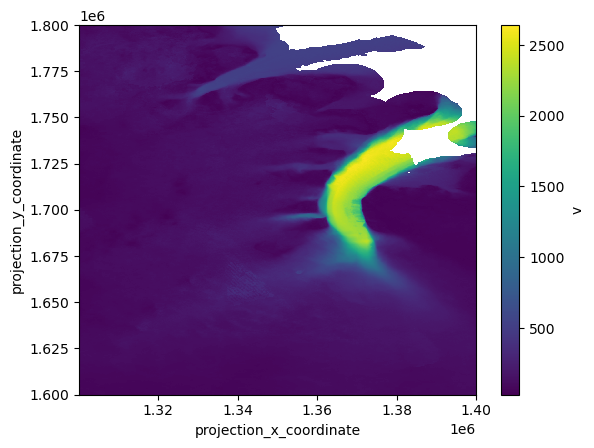

In [13]:
# Use pt_urls to load in datasets unclipped, plot v
pt_dc = bit.get_data_cube(urls=pt_urls)

pt_dc.v.mean(dim='mid_date').plot()

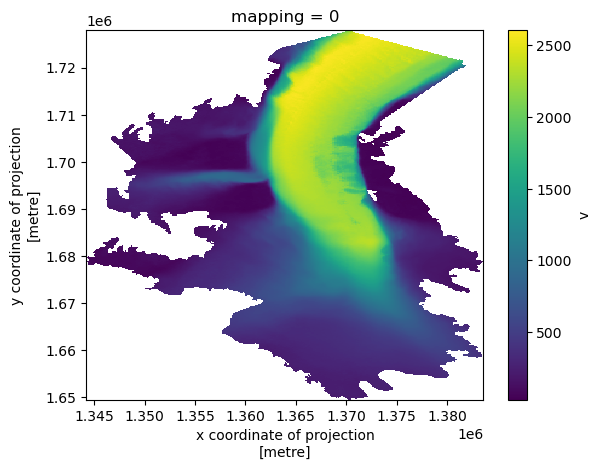

In [14]:
# Use shirase_outline shapefile and shp_urls to load in clipped ds, plot v
shp_dc = bit.get_data_cube(shape=shirase_outline, urls=shp_urls)

shp_dc.v.mean(dim='mid_date').plot()

Here you can see the value of adding the shape parameter to `bit.get_data_cube`. It will clip the region down to the outline of the shapefile. <br>
Even though the URLs passed into the function are the same, the amount of data returned and plotted is vastly different.

Next, we can see the value of the function being able to call `bit.get_urls` on its own. By only passing the outline of Shirase Glacier, we can produce the same exact plot. <br>
This allows us to save time and variables by only calling one function to produce a clipped data cube

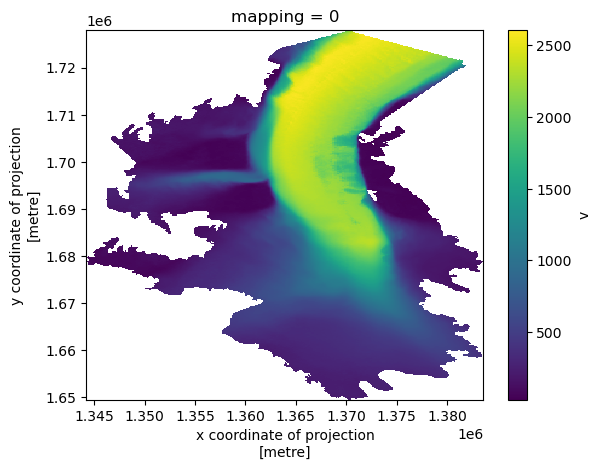

In [15]:
# Use shirase_outline shapefile to load in clipped ds, plot v
shp_dc = bit.get_data_cube(shape=shirase_outline)

shp_dc.v.mean(dim='mid_date').plot()

## Conclusion

Now you know how to load in ITS_LIVE cloud-hosted data and make simple velocity visualizations
- Add a little bit more about the resampling to monthly timeframe.